<h1 align="center">Applied Data Science - Capstone Project</h1> 
<h1 align="center">Finding suitable locations to open a Gym in Singapore</h1> 



### 1. Introduction / Business Problem
The aim of this project is to find suitable locations to open a **gym** in the **Singapore** greater metropolitan area 

The first requirement is that the new gym should be easily accessible by its prospective customers and more specifically it should be located **near a MRT metro station. The number of gyms already existing in an area** should also be considered so that fierce competition be avoided if possible.

Apart from the obvious intended stakeholders, entrepreneurs looking to start a gym business, similar methodology could be used for other specific types of businesses. It can serve as an initial starting point of locations to consider to start their business.

For the project objectives to be achieved, python geolocation libraries will be used, along with the Foursquare API. Also, in order to create clusters of similar candidate locations, the K-Means machine learning clustering algorithm will be used.

### 2. Data
The necessary data for this project, based on the above stated requirements, are:

<br>**-The MRT metro stations in the Singapore greater metropolitan area</br>
<br>-Number of existing gyms near each station</br>
<br>-In addition, the distance to the nearest gym for every metro station will be used**</br>

In order to obtain the data, a combination of the **geopy** Python library and the **Foursquare API** will be used:

1. ‘Central area’ will be considered as the center of Singapore. It is indeed one of the most central location in the city. I will obtain its geospatial coordinates using the geopy library

2. Having the coordinates of the ‘center’ of Singapore, the Foursquare API will be used to retrieve data for all the metro stations in Singapore greater area in a radius of 15 km

3. To find the existing gyms near the metro stations, the Foursquare API will again be used for every station. I will obtain data for all the gyms located in a radius of 750 meters of every metro station

Using the collected data, I will calculate the number of existing gyms near each station. **I will also be able to determine the minimum distance to a gym for every metro station** from the 3rd step of the above process. This minimum distance to every metro station from a gym, along with the number of already existing gyms near the station will be used as input to K-Means clustering algorithm to obtain the clusters of areas (metro stations).

### 3. Methodology
The objective of this project is to obtain information about metro stations in the greater metropolitan Singapore area with potential for opening a gym, and having as criteria:

<br>-Low number of already existing gyms</br>
<br>-Minimum distance of existing gyms to its nearby station</br>

The steps I will follow to identify potential areas (metro stations) are:

1. Consider ‘Central area’ as the ‘center’ of Singapore.
2. Based on the coordinates of Central area, I will obtain information about metro stations in a radius of 15 km using the Foursquare API. At this stage I will remove from the above dataset points that although they are identified as ‘Metro stations’ by the Foursquare API, they are only used as depots or maintenance gathering for the metro carriages.
3. After the collection of metro stations information, I will again use the Foursquare API to locate all the existing gyms in a radius of 750 meters from each station. At this stage I will only keep as my data set the results that correspond only to **Gym** / Fitness Center’ and **Gym** subcategories. I will remove the rest of the subcategories such as ‘Dance Studio’, ‘Yoga Studio’, ‘Martial Arts Dojo’ etc. I will ignore for the purpose of clusttering any metro stations that based on the results of the Foursquare API don’t have any existing gyms in their vicinity. For those, there can either be no existing data in the Foursquare database, or indeed there no existing gyms near the corresponding station. The data set will also contain the distance of each gym to the corresponding station.
4. Having the information about gyms around metro stations, I will calculate the number of existing gyms near each station as well as the minimum distance from each station to a gym using available python statistical functions.
5. The data will be normalized so that both factors (minimum distance, number of existing gyms) will have equal weight when they will be used by a machine learning method.
6. The K-Means Machine Learning clustering algorithm will be used to divide the stations and gyms data set into clusters of similar locations. The elbow method will be used to find the most suitable number of clusters.

#### Install the necessary libraries

In [1]:
!conda install -c conda-forge geopy --yes

Solving environment: done

# All requested packages already installed.



In [2]:
!conda install -c conda-forge folium --yes

Solving environment: done

# All requested packages already installed.



#### Import libraries

In [3]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import pandas as pd
# Set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from pandas.io.json import json_normalize

import folium # map rendering library

import requests

import numpy as np

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.pyplot import subplots

from sklearn import preprocessing

print('Libraries imported.')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


Libraries imported.


### Data Acquisition, Cleaning and Transformation
#### Get the geospatial coordinates of 'Syntagma Square

In [4]:
address = 'Central area, Singapore'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore - Central area Place station are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore - Central area Place station are 1.2904753, 103.8520359.


In [5]:
string = str(latitude) + ', ' +str(longitude)
address = geolocator.reverse(string, language='en')
address

Location(Downtown Core, Central, Singapore, (1.290533, 103.8521479537429, 0.0))

#### Let's show 'Central Area, Singapore' on a Map

In [6]:
map_syntagma = folium.Map(location=[latitude, longitude], zoom_start=15)
folium.Marker([1.2904753, 103.8520359], popup='Central Area').add_to(map_syntagma)
map_syntagma

Category id for metro stations: 4bf58dd8d48988d1fd931735 and the Source is https://developer.foursquare.com/docs/resources/categories
Get the metro stations in Singapore in radius of 15 km around Central Area



In [7]:
radius = 15000
VERSION = '20190620' # Foursquare API version
LIMIT = 200
category_id = '4bf58dd8d48988d1fd931735' # Metro Stations

In [8]:
CLIENT_ID = 'PA4X4U4RECFVA4LDVTOSUSS5KME0PQ1ISRWSNEQD4IAHI3N0' # your Foursquare ID
CLIENT_SECRET = 'PAY5HGR3EYMOJV30XLHDBB2K5EX4DBBS3DAIFCC4CTBTY1V2' # your Foursquare Secret
VERSION = '20180620'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PA4X4U4RECFVA4LDVTOSUSS5KME0PQ1ISRWSNEQD4IAHI3N0
CLIENT_SECRET:PAY5HGR3EYMOJV30XLHDBB2K5EX4DBBS3DAIFCC4CTBTY1V2


In [9]:
url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    category_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude,
    longitude, 
    radius,
    LIMIT
)

In [10]:
Request=requests.get(url).json()
#Request

In [11]:
# stations_list = results['response']['groups'][0]['items']
stations_list = requests.get(url).json()['response']['groups'][0]['items']
stations_init_df = pd.json_normalize(stations_list)

stations_init_df.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.labeledLatLngs,venue.location.state
0,e-0-4b205bd1f964a5202a3124e3-0,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4b205bd1f964a5202a3124e3,Bugis MRT Interchange (EW12/DT14),220 Victoria St.,1.300476,103.856094,1201,188022,SG,Singapore,Singapore,"[220 Victoria St., 188022, Singapore]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN
1,e-0-4b0d0c41f964a5206f4323e3-1,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4b0d0c41f964a5206f4323e3,Raffles Place MRT Interchange (EW14/NS26),5 Raffles Pl.,1.284516,103.851446,666,048618,SG,Singapore,Singapore,"[5 Raffles Pl., 048618, Singapore]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN
2,e-0-4bc9c49468f976b0c0c85d83-2,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4bc9c49468f976b0c0c85d83,Esplanade MRT Station (CC3),90 Bras Basah Rd.,1.292907,103.855946,512,189562,SG,Singapore,Singapore,"[90 Bras Basah Rd., 189562, Singapore]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],"[{'label': 'display', 'lat': 1.2929069745655162, 'lng': 103.85594590121967}]",NaN
3,e-0-4bd70f1b7b1876b022818d86-3,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4bd70f1b7b1876b022818d86,Telok Blangah MRT Station (CC28),461 Telok Blangah Rd,1.270729,103.809998,5169,109022,SG,Singapore,Singapore,"[461 Telok Blangah Rd, 109022, Singapore]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],"[{'label': 'display', 'lat': 1.2707289311508574, 'lng': 103.80999775189478}]",NaN
4,e-0-4bd7104c7b1876b0e3838d86-4,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4bd7104c7b1876b0e3838d86,Bayfront MRT Interchange (CE1/DT16),12A Bayfront Ave,1.283062,103.859167,1144,018970,SG,Singapore,Singapore,"[12A Bayfront Ave, 018970, Singapore]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],"[{'label': 'display', 'lat': 1.2830615419593563, 'lng': 103.85916709899902}]",NaN


Extract station information

In [12]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance', 'venue.location.postalCode']
stations_filtered_df = stations_init_df.loc[:, filtered_columns]

# filter the category for each row
stations_filtered_df['venue_type'] = stations_init_df['venue.categories'].apply(lambda x: dict(x[0])['name'])

# clean columns
stations_filtered_df.columns = [col.split('.')[-1] for col in stations_filtered_df.columns]

stations_df = stations_filtered_df[stations_filtered_df['venue_type'] == 'Metro Station']
stations_df = stations_df.drop('categories', axis=1)
stations_df.head()

,name,lat,lng,distance,postalCode,venue_type
0,Bugis MRT Interchange (EW12/DT14),1.300476,103.856094,1201,188022,Metro Station
1,Raffles Place MRT Interchange (EW14/NS26),1.284516,103.851446,666,048618,Metro Station
2,Esplanade MRT Station (CC3),1.292907,103.855946,512,189562,Metro Station
3,Telok Blangah MRT Station (CC28),1.270729,103.809998,5169,109022,Metro Station
4,Bayfront MRT Interchange (CE1/DT16),1.283062,103.859167,1144,018970,Metro Station


In [13]:
stations_df.shape

(30, 6)

Check that all the rows indeed represent a metro station

In [14]:
stations_df[stations_df['name'].str.find('Station') == -1]

,name,lat,lng,distance,postalCode,venue_type
0,Bugis MRT Interchange (EW12/DT14),1.300476,103.856094,1201,188022,Metro Station
1,Raffles Place MRT Interchange (EW14/NS26),1.284516,103.851446,666,048618,Metro Station
4,Bayfront MRT Interchange (CE1/DT16),1.283062,103.859167,1144,018970,Metro Station
5,Botanic Gardens MRT Interchange (CC19/DT9),1.322324,103.814880,5446,257494,Metro Station
11,Promenade MRT Interchange (CC4/DT15),1.293731,103.860465,1005,039193,Metro Station
15,City Hall MRT Interchange (EW13/NS25),1.293146,103.853053,318,179100,Metro Station
17,Dhoby Ghaut MRT Interchange (CC1/NE6/NS24),1.299225,103.845343,1226,238826,Metro Station
19,Marina Bay MRT Interchange (NS27/CE2),1.276144,103.854788,1624,018990,Metro Station
24,Chinatown MRT Interchange (NE4/DT19),1.284482,103.843842,1129,059443,Metro Station
29,Little India MRT Interchange (NE7/DT12),1.306457,103.849606,1799,229900,Metro Station


Indeed the above two rows are 'parking' places for trains. They need to be removed from the dataframe

In [15]:
# Keep only the stations that their name contains 'Station' 
stations_df = stations_df[stations_df['name'].str.contains('MRT')]
stations_df.shape

(29, 6)

Separate the Chinese and English name into two column

In [16]:
stations_df['name CH'] = stations_df['name'].apply(lambda x: x.split('(')[1].replace(')', '').strip())
stations_df['name'] = stations_df['name'].apply(lambda x: x.split('(')[0]).str.strip()

fixed_columns = [stations_df.columns[0]] + [stations_df.columns[-1]] + list(stations_df.columns[1:-1])
stations_df = stations_df[fixed_columns]
stations_df.head()

,name,name CH,lat,lng,distance,postalCode,venue_type
0,Bugis MRT Interchange,EW12/DT14,1.300476,103.856094,1201,188022,Metro Station
1,Raffles Place MRT Interchange,EW14/NS26,1.284516,103.851446,666,048618,Metro Station
2,Esplanade MRT Station,CC3,1.292907,103.855946,512,189562,Metro Station
3,Telok Blangah MRT Station,CC28,1.270729,103.809998,5169,109022,Metro Station
4,Bayfront MRT Interchange,CE1/DT16,1.283062,103.859167,1144,018970,Metro Station


Some final changes

In [17]:
stations_df.rename(columns={'name': 'station',
                            'name CH': 'station CH',
                            'distance': 'Distance from Center',
                            'postalCode': 'Postal Code',
                            'venue_type': 'Venue Type'},
                   inplace=True)

stations_df.reset_index(drop=True, inplace=True)

print(stations_df.info())
stations_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   station               29 non-null     object 
 1   station CH            29 non-null     object 
 2   lat                   29 non-null     float64
 3   lng                   29 non-null     float64
 4   Distance from Center  29 non-null     int64  
 5   Postal Code           29 non-null     object 
 6   Venue Type            29 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.7+ KB
None


,station,station CH,lat,lng,Distance from Center,Postal Code,Venue Type
0,Bugis MRT Interchange,EW12/DT14,1.300476,103.856094,1201,188022,Metro Station
1,Raffles Place MRT Interchange,EW14/NS26,1.284516,103.851446,666,048618,Metro Station
2,Esplanade MRT Station,CC3,1.292907,103.855946,512,189562,Metro Station
3,Telok Blangah MRT Station,CC28,1.270729,103.809998,5169,109022,Metro Station
4,Bayfront MRT Interchange,CE1/DT16,1.283062,103.859167,1144,018970,Metro Station


Visualize the metro stations on a Map of Singapore

In [18]:
# create map of Singapore using latitude and longitude values
map_Singapore = folium.Map(location=[1.357107, 103.8194992], zoom_start=11)

# add markers to map
for lat, lng, station in zip(stations_df['lat'],
                          stations_df['lng'],
                          stations_df['station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_Singapore)
    
map_Singapore

#### Get the gyms near the stations¶
Category id for metro stations: 4bf58dd8d48988d175941735

Source: https://developer.foursquare.com/docs/resources/categories

Function to create a dataframe with the results gathered from Foursquare API on a specific category

In [19]:
def getNearbyGyms(categoryId, stations, latitudes, longitudes, radius=750):
    
    print('Findind gyms near Singapore metro stations, please wait...\n')
    
    gyms_list=[]
    for station, lat, lng in zip(stations, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            categoryId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby gym
        gyms_list.append([(
            station,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']
        ) for v in results])

    nearby_gyms_df = pd.DataFrame([item for venue_list in gyms_list for item in venue_list])
    nearby_gyms_df.columns = [
                  'station',
                  'lat',
                  'lng',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Distance from Station',
                  'Venue Category']
    print('Finished')
    return(nearby_gyms_df)

Use the function to gather information about existing gyms in a radius of 750m around each metro station in Singapore

In [20]:
categoryId = '4bf58dd8d48988d175941735' # Gym / Fitness Center
gyms_venues_df = getNearbyGyms(categoryId, stations=stations_df['station'], latitudes=stations_df['lat'], longitudes=stations_df['lng'])

Findind gyms near Singapore metro stations, please wait...

Finished


In [21]:
gyms_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,Bugis MRT Interchange,1.300476,103.856094,Fitness First,1.299045,103.855205,187,Gym / Fitness Center
1,Bugis MRT Interchange,1.300476,103.856094,JW Marriott Hotel Singapore South Beach Fitness Centre,1.294371,103.856035,679,Gym / Fitness Center
2,Bugis MRT Interchange,1.300476,103.856094,Amore Fitness,1.298901,103.854929,218,Gym / Fitness Center
3,Bugis MRT Interchange,1.300476,103.856094,The Yoga Co.,1.302614,103.858765,380,Yoga Studio
4,Bugis MRT Interchange,1.300476,103.856094,Gym @ Carlton,1.295624,103.852768,654,Gym / Fitness Center


Let's check the categories of venues that were returned for each neighborhood

In [22]:
gyms_venues_df.groupby(['Venue Category']).count()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Building,1,1,1,1,1,1,1
Climbing Gym,3,3,3,3,3,3,3
College Gym,3,3,3,3,3,3,3
Gym,156,156,156,156,156,156,156
Gym / Fitness Center,317,317,317,317,317,317,317
Gym Pool,9,9,9,9,9,9,9
Gymnastics Gym,1,1,1,1,1,1,1
Hotel Pool,3,3,3,3,3,3,3
Martial Arts Dojo,31,31,31,31,31,31,31


#### We will only keep the two categories [Gym, Gym / Fitness Center]

In [23]:
gyms_venues_df = gyms_venues_df[gyms_venues_df['Venue Category'].isin(['Gym', 'Gym / Fitness Center'])]
gyms_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,Bugis MRT Interchange,1.300476,103.856094,Fitness First,1.299045,103.855205,187,Gym / Fitness Center
1,Bugis MRT Interchange,1.300476,103.856094,JW Marriott Hotel Singapore South Beach Fitness Centre,1.294371,103.856035,679,Gym / Fitness Center
2,Bugis MRT Interchange,1.300476,103.856094,Amore Fitness,1.298901,103.854929,218,Gym / Fitness Center
4,Bugis MRT Interchange,1.300476,103.856094,Gym @ Carlton,1.295624,103.852768,654,Gym / Fitness Center
5,Bugis MRT Interchange,1.300476,103.856094,Fitness Center,1.299450,103.857654,207,Gym / Fitness Center


Make sure that the not needed venues were removed

In [24]:
gyms_venues_df.groupby(['Venue Category']).count().head(10)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Gym,156,156,156,156,156,156,156
Gym / Fitness Center,317,317,317,317,317,317,317


***Add distance from each metro station to the nearest gym and number of existing gyms in its vicinity***
Add to the data frame the minimum distance of every station to the gyms in its vicinity

In [25]:
gyms_venues_min_df = pd.merge(gyms_venues_df,
                              pd.DataFrame(gyms_venues_df.groupby('station')['Distance from Station'].min()),
                              on='station', how='inner')

In [26]:
gyms_venues_min_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y
0,Bugis MRT Interchange,1.300476,103.856094,Fitness First,1.299045,103.855205,187,Gym / Fitness Center,187
1,Bugis MRT Interchange,1.300476,103.856094,JW Marriott Hotel Singapore South Beach Fitness Centre,1.294371,103.856035,679,Gym / Fitness Center,187
2,Bugis MRT Interchange,1.300476,103.856094,Amore Fitness,1.298901,103.854929,218,Gym / Fitness Center,187
3,Bugis MRT Interchange,1.300476,103.856094,Gym @ Carlton,1.295624,103.852768,654,Gym / Fitness Center,187
4,Bugis MRT Interchange,1.300476,103.856094,Fitness Center,1.299450,103.857654,207,Gym / Fitness Center,187


Add the number of already existing gyms in the vicinity of each station

In [27]:
gyms_venues_min_count_df = pd.merge(gyms_venues_min_df,
                           pd.DataFrame(gyms_venues_min_df.groupby(['station']).count())['lat'],
                           on='station', how='inner')

In [28]:
gyms_venues_min_count_df.head()

,station,lat_x,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y,lat_y
0,Bugis MRT Interchange,1.300476,103.856094,Fitness First,1.299045,103.855205,187,Gym / Fitness Center,187,24
1,Bugis MRT Interchange,1.300476,103.856094,JW Marriott Hotel Singapore South Beach Fitness Centre,1.294371,103.856035,679,Gym / Fitness Center,187,24
2,Bugis MRT Interchange,1.300476,103.856094,Amore Fitness,1.298901,103.854929,218,Gym / Fitness Center,187,24
3,Bugis MRT Interchange,1.300476,103.856094,Gym @ Carlton,1.295624,103.852768,654,Gym / Fitness Center,187,24
4,Bugis MRT Interchange,1.300476,103.856094,Fitness Center,1.299450,103.857654,207,Gym / Fitness Center,187,24


In [29]:
gyms_df = gyms_venues_min_count_df.rename(columns={'lat_x': 'lat', 'Distance from Station_x': 'Distance from Station',
                                                   'Distance from Station_y': 'Min Distance from Station',
                                                   'lat_y': 'Gym Count'})
gyms_df.head(15)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category,Min Distance from Station,Gym Count
0,Bugis MRT Interchange,1.300476,103.856094,Fitness First,1.299045,103.855205,187,Gym / Fitness Center,187,24
1,Bugis MRT Interchange,1.300476,103.856094,JW Marriott Hotel Singapore South Beach Fitness Centre,1.294371,103.856035,679,Gym / Fitness Center,187,24
2,Bugis MRT Interchange,1.300476,103.856094,Amore Fitness,1.298901,103.854929,218,Gym / Fitness Center,187,24
3,Bugis MRT Interchange,1.300476,103.856094,Gym @ Carlton,1.295624,103.852768,654,Gym / Fitness Center,187,24
4,Bugis MRT Interchange,1.300476,103.856094,Fitness Center,1.299450,103.857654,207,Gym / Fitness Center,187,24
5,Bugis MRT Interchange,1.300476,103.856094,Virgin Active Duo Galleria,1.299588,103.858585,294,Gym / Fitness Center,187,24
6,Bugis MRT Interchange,1.300476,103.856094,Jay Devaraj Thevar,1.297122,103.855442,380,Gym / Fitness Center,187,24
7,Bugis MRT Interchange,1.300476,103.856094,Croyez Studio @ Purvis Street,1.296616,103.855019,446,Gym / Fitness Center,187,24
8,Bugis MRT Interchange,1.300476,103.856094,Clark Hatch Fitness Center,1.298063,103.855019,294,Gym,187,24
9,Bugis MRT Interchange,1.300476,103.856094,The Brass Barre,1.297822,103.853184,438,Gym / Fitness Center,187,24


In [30]:
gyms_df = gyms_df[['station', 'lat', 'lng', 'Min Distance from Station', 'Gym Count']].drop_duplicates()

In [31]:
gyms_df.head(10)

,station,lat,lng,Min Distance from Station,Gym Count
0,Bugis MRT Interchange,1.300476,103.856094,187,24
24,Raffles Place MRT Interchange,1.284516,103.851446,11,27
51,Esplanade MRT Station,1.292907,103.855946,106,28
79,Telok Blangah MRT Station,1.270729,103.809998,365,4
83,Bayfront MRT Interchange,1.283062,103.859167,119,6
89,Botanic Gardens MRT Interchange,1.322324,103.814880,278,2
91,Telok Ayer MRT Station,1.282401,103.848756,26,28
119,Clarke Quay MRT Station,1.288804,103.846968,29,28
147,Nicoll Highway MRT Station,1.300246,103.863451,156,6
153,Novena MRT Station,1.320086,103.843592,23,11


In our initial stations dataframe, after the two non-real metro stations were removed. Check how many metro stations were returned from the Foursquare API with already existing gyms

In [32]:
gyms_df.shape

(28, 5)

***It seems that we are missing stations from the original. They probably did not have any gyms in their vicinity or there are no data available for these stations. We need to keep them in mind for any future further investigation. For now these two stations will be ignored***

We will merge the initial stations_df dataframe with the previously created gyms_df and assign 10000 to 'Min Distance from Station' and 0 to 'Gym Count'

In [33]:
missing_stations_df = pd.merge(stations_df[['station', 'lat', 'lng']], gyms_df,
                                    on='station', how='left')
missing_stations_df[missing_stations_df['Gym Count'].isnull()]

,station,lat_x,lng_x,lat_y,lng_y,Min Distance from Station,Gym Count
14,Marina South Pier MRT Station,1.271067,103.863216,NaN,NaN,NaN,NaN


So the One metro stations for which no data were returned from the Foursquare API is **Marina South Pier MRT Station**

Now is a good time to make a copy of the dataframe that was created

In [34]:
stations_gyms_grouped_df = gyms_df.copy()

In [35]:
stations_gyms_grouped_df.shape

(28, 5)

In [36]:
stations_gyms_grouped_df.head()

,station,lat,lng,Min Distance from Station,Gym Count
0,Bugis MRT Interchange,1.300476,103.856094,187,24
24,Raffles Place MRT Interchange,1.284516,103.851446,11,27
51,Esplanade MRT Station,1.292907,103.855946,106,28
79,Telok Blangah MRT Station,1.270729,103.809998,365,4
83,Bayfront MRT Interchange,1.283062,103.859167,119,6


#### Normalize Data [Min Distance from Station, Gym Count]
Data Standardization give data zero mean and unit variance

In [37]:
print('All stations mean distance from any gym: ', stations_gyms_grouped_df['Min Distance from Station'].mean())
print('All stations maximum distance from any gym: ',stations_gyms_grouped_df['Min Distance from Station'].max())
print('All stations minimum distance from any gym: ', stations_gyms_grouped_df['Min Distance from Station'].min())
print('All stations mean of number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].mean())
print('All stations maximum number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].max())
print('All stations minimum number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].min())

All stations mean distance from any gym:  184.17857142857142
All stations maximum distance from any gym:  513
All stations minimum distance from any gym:  11
All stations mean of number of existing gyms:  16.892857142857142
All stations maximum number of existing gyms:  28
All stations minimum number of existing gyms:  2


In [38]:

stations_gyms_grouped_df['Norm Min Distance from Station'] = (stations_gyms_grouped_df['Min Distance from Station'] - \
                                                              stations_gyms_grouped_df['Min Distance from Station'].mean()) / \
                                                             (stations_gyms_grouped_df['Min Distance from Station'].max() - \
                                                              stations_gyms_grouped_df['Min Distance from Station'].min())
stations_gyms_grouped_df['Norm Gym Count'] = (stations_gyms_grouped_df['Gym Count'] - stations_gyms_grouped_df['Gym Count'].mean()) / \
                                             (stations_gyms_grouped_df['Gym Count'].max() - stations_gyms_grouped_df['Gym Count'].min())

In [39]:

stations_gyms_grouped_df['Gym Count'] = stations_gyms_grouped_df['Gym Count'].astype(int)

In [40]:
stations_gyms_grouped_df.reset_index(drop=True, inplace=True)

In [41]:
stations_gyms_grouped_df.head(10)

,station,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,Bugis MRT Interchange,1.300476,103.856094,187,24,0.005620,0.273352
1,Raffles Place MRT Interchange,1.284516,103.851446,11,27,-0.344977,0.388736
2,Esplanade MRT Station,1.292907,103.855946,106,28,-0.155734,0.427198
3,Telok Blangah MRT Station,1.270729,103.809998,365,4,0.360202,-0.495879
4,Bayfront MRT Interchange,1.283062,103.859167,119,6,-0.129838,-0.418956
5,Botanic Gardens MRT Interchange,1.322324,103.814880,278,2,0.186895,-0.572802
6,Telok Ayer MRT Station,1.282401,103.848756,26,28,-0.315097,0.427198
7,Clarke Quay MRT Station,1.288804,103.846968,29,28,-0.309121,0.427198
8,Nicoll Highway MRT Station,1.300246,103.863451,156,6,-0.056133,-0.418956
9,Novena MRT Station,1.320086,103.843592,23,11,-0.321073,-0.226648


#### K-Means Clustering
***Prepare the dataframe to be used in K-Means algorithm***

In [42]:
gyms_clustering_df = stations_gyms_grouped_df.drop(['station', 'lat', 'lng', 'Min Distance from Station', 'Gym Count'], 1)

In [43]:
gyms_clustering_df.head()

,Norm Min Distance from Station,Norm Gym Count
0,0.005620,0.273352
1,-0.344977,0.388736
2,-0.155734,0.427198
3,0.360202,-0.495879
4,-0.129838,-0.418956


***Cluster Locations (Metro stations) in Singapore (K-Means Clustering)***
<br>The KMeans class has many parameters that can be used, but we will be using these three:</br>



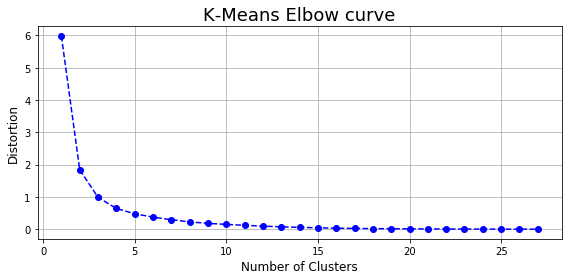

In [44]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(1, 28):
    kmeans = KMeans(init="k-means++", n_clusters=k, random_state=0, n_init = 12, max_iter=300, tol=0.00001)
    kmeans.fit(gyms_clustering_df)
    distorsions.append(kmeans.inertia_)

fig, ax = subplots(figsize=(8, 4))
ax.plot(range(1, 28), distorsions, '--bo')
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Distortion', fontsize=12)
plt.grid(True)
plt.title('K-Means Elbow curve', fontsize='18')
plt.tight_layout()
plt.show()

***Run k-means to cluster the station areas to 3 clusters***

In [45]:
# venues_grouped_clustering_df = venues_grouped_df.drop('station', 1)
kmeans = KMeans(init="k-means++", n_clusters=3, random_state=0, n_init = 12, max_iter=300, tol=0.0001)
kmeans.fit(gyms_clustering_df)

kmeans.labels_

array([1, 1, 1, 0, 2, 0, 1, 1, 2, 2, 2, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 2,
       1, 1, 0, 0, 1, 0], dtype=int32)

#### 4. K-Means Clustering Results
***Create a new dataframe that includes the resulted clusters and relevant metro station information***

In [46]:
# add clustering labels
stations_gyms_grouped_df.insert(1, 'Cluster Label', kmeans.labels_)

In [47]:
stations_gyms_grouped_df.head()

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,Bugis MRT Interchange,1,1.300476,103.856094,187,24,0.005620,0.273352
1,Raffles Place MRT Interchange,1,1.284516,103.851446,11,27,-0.344977,0.388736
2,Esplanade MRT Station,1,1.292907,103.855946,106,28,-0.155734,0.427198
3,Telok Blangah MRT Station,0,1.270729,103.809998,365,4,0.360202,-0.495879
4,Bayfront MRT Interchange,2,1.283062,103.859167,119,6,-0.129838,-0.418956


Visualize the metro stations clusters on a map of Singapore

In [48]:

cluster_colors = ['orange', 'red', 'blue'] #, 'green', 'purple', 'pink', 'purple', 'lightblue', 'yellow']

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

markers_colors = []
for lat, lon, poi, cluster in zip(stations_gyms_grouped_df['lat'], stations_gyms_grouped_df['lng'], 
                                  stations_gyms_grouped_df['station'], stations_gyms_grouped_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster_colors[cluster],
        fill=True,
        fill_color=cluster_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now visualize the (normalized) clusters distribution on a scatter plot along with their final corresponding centroids

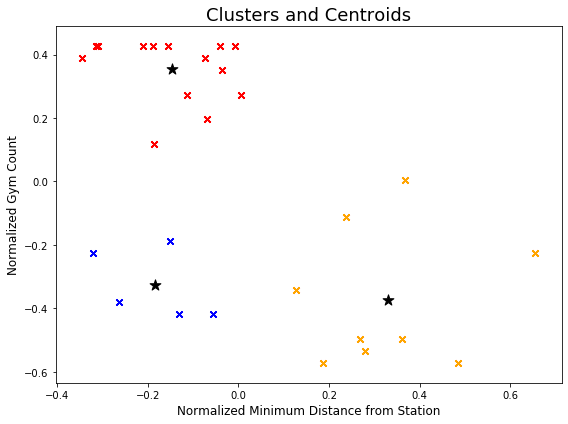

In [49]:

fig, ax = subplots(figsize=(8, 6))
for label in kmeans.labels_:
    plt.scatter(stations_gyms_grouped_df[stations_gyms_grouped_df['Cluster Label'] == label]['Norm Min Distance from Station'],
                stations_gyms_grouped_df[stations_gyms_grouped_df['Cluster Label'] == label]['Norm Gym Count'],
                marker='x', color=cluster_colors[label])
for centroid in kmeans.cluster_centers_:
#     print(centroid)
    plt.scatter(centroid[0], centroid[1], s=130, marker="*", color='black')
ax.set_xlabel('Normalized Minimum Distance from Station', fontsize=12)
ax.set_ylabel('Normalized Gym Count', fontsize=12)
plt.title('Clusters and Centroids', fontsize='18')
plt.tight_layout()
plt.show()

##### Show the Metro stations that correspond to each cluster
#### Cluster 1 (AVERAGE potential)
Although not a prohibitive metro station to open a gym in its vicinity, there is already a fair number of gyms in the area and the nearest one is not far from the metro station

In [50]:

stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 0]

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
3,Telok Blangah MRT Station,0,1.270729,103.809998,365,4,0.360202,-0.495879
5,Botanic Gardens MRT Interchange,0,1.322324,103.814880,278,2,0.186895,-0.572802
12,Tiong Bahru MRT Station,0,1.285758,103.826982,325,3,0.280521,-0.534341
15,Pasir Panjang MRT Station,0,1.276075,103.791973,427,2,0.483708,-0.572802
18,Marina Bay MRT Interchange,0,1.276144,103.854788,303,14,0.236696,-0.111264
19,Braddell MRT Station,0,1.340742,103.847020,319,4,0.268569,-0.495879
24,Rochor MRT Station,0,1.303877,103.852635,369,17,0.368170,0.004121
25,Jalan Besar MRT Station,0,1.305004,103.855339,513,11,0.655023,-0.226648
27,Little India MRT Interchange,0,1.306457,103.849606,248,8,0.127134,-0.342033


#### Cluster 2 (LOW potential])
There are already many existing gyms in the area and the nearest gym is in most cases in a relatively short distance from the station

In [51]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 1]

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,Bugis MRT Interchange,1,1.300476,103.856094,187,24,0.005620,0.273352
1,Raffles Place MRT Interchange,1,1.284516,103.851446,11,27,-0.344977,0.388736
2,Esplanade MRT Station,1,1.292907,103.855946,106,28,-0.155734,0.427198
6,Telok Ayer MRT Station,1,1.282401,103.848756,26,28,-0.315097,0.427198
7,Clarke Quay MRT Station,1,1.288804,103.846968,29,28,-0.309121,0.427198
11,Promenade MRT Interchange,1,1.293731,103.860465,91,20,-0.185615,0.119505
13,Fort Canning MRT Station,1,1.292371,103.844272,164,28,-0.040196,0.427198
14,City Hall MRT Interchange,1,1.293146,103.853053,90,28,-0.187607,0.427198
16,Dhoby Ghaut MRT Interchange,1,1.299225,103.845343,149,22,-0.070077,0.196429
17,Bras Basah MRT Station,1,1.297506,103.850506,147,27,-0.074061,0.388736


#### Cluster 3 (HIGH potential)
There are not many already existing gyms in the area and the nearest gym is in most cases relatively not in a short distance to the metro station

In [52]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 2]

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
4,Bayfront MRT Interchange,2,1.283062,103.859167,119,6,-0.129838,-0.418956
8,Nicoll Highway MRT Station,2,1.300246,103.863451,156,6,-0.056133,-0.418956
9,Novena MRT Station,2,1.320086,103.843592,23,11,-0.321073,-0.226648
10,Lavender MRT Station,2,1.307418,103.862860,108,12,-0.151750,-0.188187
21,Holland Village MRT Station,2,1.311008,103.795959,52,7,-0.263304,-0.380495


### Discussion
Clusters of areas (in our case Metro stations) were identified as groups of similar in their potential locations for opening a gym.

Possible areas that were not in the Foursquare database should also be examined so that it can be determined if it is just lack of data about these stations or indeed there are no gyms in the vicinity of the stations. A lot more factors can be considered when choosing an appropriate location. Some examples of extra factors can be:

Population density in the area
Number of businesses operating in the area (people may want to go to a gym close to work)
Average age and household income in the area
Property prices in the area

### Conclusion
The above results can be a good starting point for a prospective businessman that is interested in opening a gym. Similar methodology can be used for other types of businesses probably with customized criteria.

With the availability of a number of different tools and Machine Learning algorithms, it is possible to find solutions (or possible solutions) to an ever increasing number of problems and queries.

And it is getting better and better!

# Thank You